# Debug test

In [3]:
import qubit_system as qs
import plot_lib as pl
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle

import sys
np.set_printoptions(threshold=sys.maxsize)


def r2matrix(r_dic):
    n = len(r_dic)
    r = [[0] * n for _ in range(n)]
    
    for i, key_i in enumerate(r_dic):
        for j, key_j in enumerate(r_dic):
            if j >= i:
                r[i][j] = r_dic.get(f"r{i+1}{j+1}", 0)
    return r

def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)

    return nested_var_name2str(variable)

def write_data(output_file, data):
    # Write the simu_data dictionary to a local file using pickle
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    with open(output_file, "wb") as file:
        pickle.dump(data, file)

def load_data(input_file):
    # Load the data from the file using pickle
    with open(input_file, "rb") as file:
        loaded_data = pickle.load(file)
    return loaded_data
    

## Setup system

$ H_0 + H_d $

In [2]:
N =4 # Maximum excitation level
w = [6.3, 5.85, 6.2] # Qubit frequency
q_dim = [4 for _ in range(len(w))]
alpha =[-0.3, -0.3, -0.2] # Anharmonicity
# r_dic = {
#     "r12": 0,#0.05,
#     "r13": 0,#-0.005,
#     "r23": 0#0.05
# }

r_dic = {
    "r12": 0.05,
    "r13": -0.005,
    "r23": 0.05
}

r = r2matrix(r_dic) # Coupling strength

gamma_list = [
    {
        "up": 0.005,
        "down": 0.1,
        "z": 0.001
    },
    {
        "up": 0,
        "down": 0,
        "z": 0
    },
    {
        "up": 0.005,
        "down": 0.1,
        "z": 0.001
    }
]  # Gamma up, Gamma down, Gamma z

# Set up system class
_system = qs.qubit_system(N, q_dim, w, alpha, r, gamma_list)

# Get system Hamiltonian
print(_system.H)

Quantum object: dims = [[4, 4, 4], [4, 4, 4]], shape = (32, 32), type = oper, isherm = False
Qobj data =
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  3.14159265e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.14159265e-02  0.00000000e+00
   0.00000000e+00  3.14159265e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.89557489e+01  0.00000000e+00  0.00000000e+00
   3.14159265e-01  0.00000000e+00  4.44288294e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.14159265e-02  0.00000000e+00 -4.44288294e-02
   0.00000000e+00  0.00000000e+00  3.14159265e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0

## ZZ coupling strength

In [4]:
# Path to the output file
output_file = "DATA/zz/DATA.pkl"

N = 4 # Maximum excitation level
w = [7, 5, 6.6] # Qubit frequency
q_dim = [4 for _ in range(len(w))]
alpha =[-0.24, -0.14, -0.24] # Anharmonicity
r_dic = {
    "r12": 0.11,
    "r13": -0.006,
    "r23": 0.11
}
r = r2matrix(r_dic) # Coupling strength
gamma_list = None # Gamma up, Gamma down, Gamma z

# Define scanning space
w2_scan_space = np.linspace(5, 8, 41)
w3_scan_space = np.linspace(6.6, 7.4, 11)

# Scanning
zz_list = []

for w3 in w3_scan_space:
    dummy_list = []
    w = [7, 5, w3]
    zz_system1 = qs.qubit_system(N, q_dim, w, alpha, r, gamma_list)
    # State represented in tuple, e.g., |100> ==> (1,0,0)
    index_101 = zz_system1.get_state_index((1,0,1))
    index_100 = zz_system1.get_state_index((1,0,0))
    index_001 = zz_system1.get_state_index((0,0,1))
    index_000 = zz_system1.get_state_index((0,0,0))
    for w2 in w2_scan_space:
        w = [7, w2, w3]
        zz_system = qs.qubit_system(N, q_dim, w, alpha, r, gamma_list)
        E_101 = zz_system.H.eigenenergies()[index_101]/np.pi/2
        E_100 = zz_system.H.eigenenergies()[index_100]/np.pi/2
        E_001 = zz_system.H.eigenenergies()[index_001]/np.pi/2
        E_000 = zz_system.H.eigenenergies()[index_000]/np.pi/2
        
        dummy_list.append((- E_101 + E_100 + E_001 - E_000).real)
    zz_list.append(dummy_list)

# Write in data
simu_data = {
    "zz": zz_list,
    "w2_scan_space": w2_scan_space,
    "w3_scan_space": w3_scan_space
}
write_data(output_file, simu_data)

### Plot zz interaction

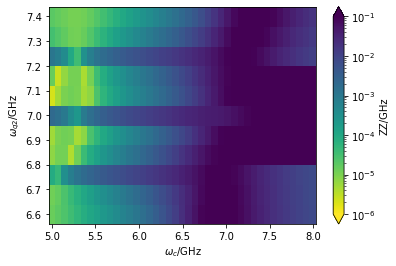

0

In [5]:
# Path to the input file
input_file = "DATA/zz/DATA.pkl"

W = load_data(input_file)
w2_scan_space = W["w2_scan_space"]
w3_scan_space = W["w3_scan_space"]
zz_list = W["zz"]

x_list, y_list = np.meshgrid(w2_scan_space, w3_scan_space)
zz_list=np.abs(zz_list)

pl.plot_zz_sweep(x_list, y_list, zz_list, "\omega_c", "\omega_{q2}")

## Energy level

In [2]:
# Path to the output file
output_file = "DATA/energy_level/DATA.pkl"

N = 4 # Maximum excitation level
w = [7, 0, 6.6] # Qubit frequency
q_dim = [4 for _ in range(len(w))]
alpha =[-0.24, -0.14, -0.24] # Anharmonicity
r_dic = {
    "r12": 0.11,
    "r13": 0.006,
    "r23": 0.11
}
r = r2matrix(r_dic) # Coupling strength
gamma_list = None # Gamma up, Gamma down, Gamma z

num_level = 20 # Num of level we want to see
w2_scan_space= np.linspace(5.5, 8, 101)
energy_level_list = []

for w2 in w2_scan_space:
    dummy_list = []
    w[1] = w2
    _system = qs.qubit_system(N, q_dim, w, alpha, r, gamma_list)
    for j in range(0,num_level):
        dummy_list.append((_system.H.eigenenergies()[j] / np.pi/2).real)
    energy_level_list.append(dummy_list)

# Write in data
simu_data = {
    "energy_level": energy_level_list,
    "w2_scan_space": w2_scan_space,
}
write_data(output_file, simu_data)

### Plot energy level 

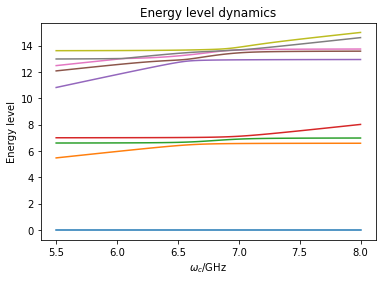

0

In [5]:
# Load data
# Path to the input file
input_file = "DATA/energy_level/DATA.pkl"
W = load_data(input_file)
w2_scan_space = W["w2_scan_space"]
energy_level_list = W["energy_level"]

pl.plot_Elevel_dynamics(w2_scan_space, energy_level_list, "\omega_c")

## System Dynamics

In [18]:
output_file = "DATA/dynamics/DATA.pkl"

N = 4 # Maximum excitation level
w = [6.3, 5.85, 6.2] # Qubit frequency
q_dim = [4 for _ in range(len(w))]
alpha =[-0.3, -0.3, -0.2] # Anharmonicity
r_dic = {
    "r12": 0.05,
    "r13": -0.005,
    "r23": 0.05
}
r = r2matrix(r_dic) # Coupling strength
gamma_list = None

_system = qs.qubit_system(N, q_dim, w, alpha, r, gamma_list)

# Get level spacing between |010> and |000>
# State represented in tuple, e.g., |100> ==> (1,0,0)
state_010, E_010, _ = _system.get_eigenstates_energy((0,1,0))
state_000, E_000, _ = _system.get_eigenstates_energy((0,0,0))
Delta_E = E_010 - E_000
print("E_010 - E_000 = {}".format(Delta_E))

simulation_option = {
    "simulation_time": 200, # ns
    "simulation_step": 2000,
    "initial_state": [state_000] # Do multiple simulation
}

pulse_sequence = [
    {
        'pulse_index': 1,
        'type': "XY",
        'pulse_shape': "cos",
        't_delay': 0,
        't_width': 200,
        't_plateau': 0,
        'freq': Delta_E,
        'amplitude': 0.01,
        'q_index': 1 # 0, 1, 2
    }
]

# Another example of a pulse sequence
pulse_sequence_example = [
    {
        'pulse_index': 1,
        'type': "XY",
        'pulse_shape': "cos",
        't_delay': 300,
        't_width': 200,
        't_plateau': 0,
        'freq': Delta_E,
        'amplitude': 0.8,
        'q_index': 1
    },
    {
        'pulse_index': 2,
        'type': "XY",
        'pulse_shape': "cos",
        't_delay': 200,
        't_width': 300,
        't_plateau': 0,
        'freq': Delta_E,
        'amplitude': 0.73,
        'q_index': 0
    },
    {
        'pulse_index': 3,
        'type': "Z",
        'pulse_shape': "sin",
        't_delay': 100,
        't_width': 50,
        't_plateau': 100,
        'freq': Delta_E,
        'amplitude': 0.9,
        'q_index': 1
    },
    {
        'pulse_index': 4,
        'type': "Z",
        'pulse_shape': "sin",
        't_delay': 0,
        't_width': 50,
        't_plateau': 0,
        'freq': Delta_E,
        'amplitude': 0.9,
        'q_index': 0
    },
    {
        'pulse_index': 5,
        'type': "XY",
        'pulse_shape': "cos",
        't_delay': 125,
        't_width': 100,
        't_plateau': 0,
        'freq': Delta_E,
        'amplitude': 0.9,
        'q_index': 1
    }
]

E_010 - E_000 = 5.837099975436753


### Plot pulse sequence

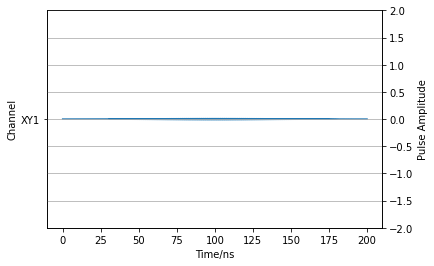

0

In [19]:
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

### Do system dynamics

In [20]:
result_list, angle_list = _system.system_dynamics(simulation_option, pulse_sequence)

# Write in data
simu_data = {
    "result_list": result_list,
    "angle_list": angle_list,
    "_system": _system,
    "simulation_option": simulation_option
}
write_data(output_file, simu_data)

### Plot level dynamics

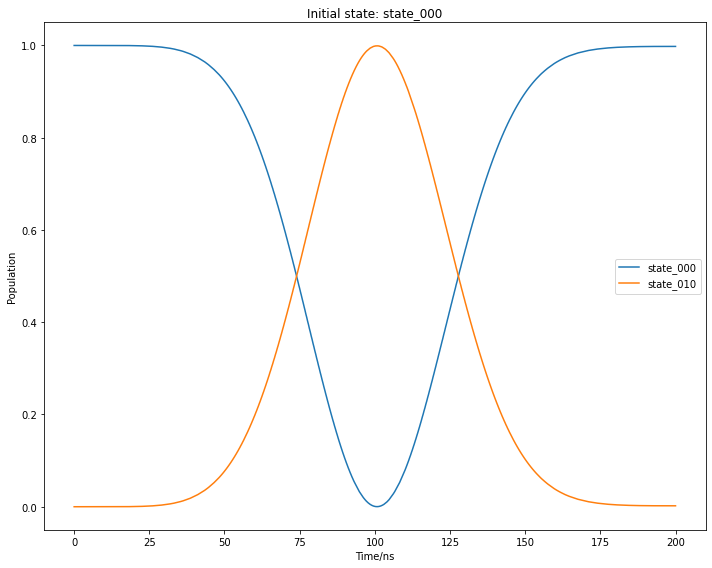

0

In [21]:
# Load data
input_file = "DATA/dynamics/DATA.pkl"
W = load_data(input_file)
result_list = W["result_list"]
angle_list = W["angle_list"]
_system = W["_system"]
simulation_option = W["simulation_option"]

# Define more states
state_100, _, _ = _system.get_eigenstates_energy((1,0,0))
state_001, _, _ = _system.get_eigenstates_energy((0,0,1))
state_110, _, _ = _system.get_eigenstates_energy((1,1,0))
state_011, _, _ = _system.get_eigenstates_energy((0,1,1))
state_101, _, _ = _system.get_eigenstates_energy((1,0,1))

# state that you want to plot each simulation
interested_state = [
                    [state_000, state_010]
                    ]
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

# plot state population evolution
pl.plot_population_evolution(_system, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

### Revise

> 1. sys_dynamics: more input state (initial states) **Done**
> 2. Get state phase. `np.angle()` **Done**
> 3. pulse sequence display  **Done**
> 4. Revise the scanning methods, just like what they did in Nlab
> 5. Regularization of the plot
>
> 6. Add propagator => calculation $ F $
> 7. Using `enr_` to define Hamiltonian Qobj **Done**
> 8. Data write in and out **Done**
> 9. More pulse waveforms
> 10. vlin? A better scanning?